In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
import glob

def get_study_site(fp):
    fp = fp.lower()
    if "texas" in fp:
        study_site = "Texas"
    elif "nebraska" in fp:
        study_site = "Nebraska"
    elif "canada" in fp:
        study_site = 'Canada'
    else:
        study_site = "Unknown"
    return study_site

def get_otm(fp):
    csv_name = fp.split('/')[-1]
    otm_name = csv_name.split('_')[0]
    if otm_name == 'AirtempNE22':
        otm_name = 'Air Temperature'
    elif otm_name == 'Air':
        otm_name = 'Air Temperature'
    elif otm_name == 'OTM':
        otm_name = otm_name + csv_name.split('_')[1]
    return otm_name

def get_csv_file_name(fp):
    return fp.split('/')[-1]

def get_microhabitat(csv_name):
    csv_name = csv_name.lower()
    if "open" in csv_name:
        mh = "Open"
    elif "shrub" in csv_name:
        mh = "Shrub"
    elif "half" in csv_name:
        mh = "Half_Burrow"
    elif "burrow" in csv_name:
        mh = 'Burrow'
    elif "grass" in csv_name:
        mh = 'Grass'
    elif "air" in csv_name:
        mh = 'Air'
    else:
        mh = "Unknown"
    return mh

data_folders = ['/mnt/c/Users/micha/Desktop/therma_sim_backup/Empirical_Data/OTM_Data_202504/OTM_Data/Canada/OTM_Data_Canada_2022/',
                '/mnt/c/Users/micha/Desktop/therma_sim_backup/Empirical_Data/OTM_Data_202504/OTM_Data/Canada/OTM_Data_Canada_2023/',
                '/mnt/c/Users/micha/Desktop/therma_sim_backup/Empirical_Data/OTM_Data_202504/OTM_Data/Nebraska/',
                '/mnt/c/Users/micha/Desktop/therma_sim_backup/Empirical_Data/OTM_Data_202504/OTM_Data/Nebraska/OTM_Data_Nebraska_23_24/',
                '/mnt/c/Users/micha/Desktop/therma_sim_backup/Empirical_Data/OTM_Data_202504/OTM_Data/Nebraska/OTM_Nebraska_24_25/',
                '/mnt/c/Users/micha/Desktop/therma_sim_backup/Empirical_Data/OTM_Data_202504/OTM_Data/Texas/Marathon/OTM_DATA_MG_2021/',
                '/mnt/c/Users/micha/Desktop/therma_sim_backup/Empirical_Data/OTM_Data_202504/OTM_Data/Texas/Marathon/OTM_DATA_MG_2023_2024/',
                ]

otm_main = pd.DataFrame()
for folder in data_folders:
    csv_files = glob.glob(folder + "*.csv")
    for csv_file in csv_files:
        col_names = ['Date', 'Unit', 'Temperature']
        temp_df = pd.read_csv(csv_file,names = col_names, skiprows=20, header=None)
        temp_df['Date'] = temp_df['Date']
        temp_df['Study_Site'] = [get_study_site(folder) for i in range(len(temp_df))]
        temp_df['Microhabitat'] = [get_microhabitat(csv_file) for i in range(len(temp_df))]
        temp_df['OTM_ID'] = [get_otm(csv_file) for i in range(len(temp_df))]
        temp_df['file_name'] = [get_csv_file_name(csv_file) for i in range(len(temp_df))]
        otm_main = pd.concat([otm_main, temp_df], ignore_index=True)
        
otm_main['Date'] = pd.to_datetime(otm_main['Date'])
otm_main['year'] = otm_main['Date'].dt.year
otm_main['month'] = otm_main['Date'].dt.month
otm_main['day'] = otm_main['Date'].dt.day
otm_main['hour'] = otm_main['Date'].dt.hour
otm_main['minute'] = otm_main['Date'].dt.minute
otm_main = otm_main[~((otm_main['Study_Site'] == 'Nebraska') & 
                      (otm_main['Date'] > '2024-09-01'))]


/tmp/ipykernel_21040/2688822329.py:73: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  otm_main['Date'] = pd.to_datetime(otm_main['Date'])


In [3]:
otm_main = otm_main[
    otm_main['Microhabitat'].isin(['Open', 'Burrow', 'Half_Burrow'])
].reset_index(drop=True)
otm_main.head()

,Date,Unit,Temperature,Study_Site,Microhabitat,OTM_ID,file_name,year,month,day,hour,minute
0,2022-06-17 23:00:01,C,19.560,Canada,Half_Burrow,OTM10,OTM10_halfburrow_CAN_2022.csv,2022,6,17,23,0
1,2022-06-18 00:10:01,C,18.058,Canada,Half_Burrow,OTM10,OTM10_halfburrow_CAN_2022.csv,2022,6,18,0,10
2,2022-06-18 01:20:01,C,18.058,Canada,Half_Burrow,OTM10,OTM10_halfburrow_CAN_2022.csv,2022,6,18,1,20
3,2022-06-18 02:30:01,C,16.556,Canada,Half_Burrow,OTM10,OTM10_halfburrow_CAN_2022.csv,2022,6,18,2,30
4,2022-06-18 03:40:01,C,16.055,Canada,Half_Burrow,OTM10,OTM10_halfburrow_CAN_2022.csv,2022,6,18,3,40


In [4]:
start_date = "2022-11-01"
end_date   = "2023-04-15"

mask = (
    (otm_main['Study_Site'] == 'Nebraska') &
    (otm_main['Microhabitat'] == 'Half_Burrow') &
    (otm_main['OTM_ID'] == 'OTM3') &
    (otm_main['Date'] >= start_date) &
    (otm_main['Date'] <= end_date)
)

otm_main = otm_main[~mask]

In [5]:
# Ensure datetime
otm_main['Date'] = pd.to_datetime(otm_main['Date'], errors='coerce')

# Make a day column with no time component
otm_main['_Day'] = otm_main['Date'].dt.floor('D')

days_to_drop = 21  # how many last days to remove

# Mark last N days for each OTM_ID
mask_last_days = (
    otm_main.groupby('OTM_ID')['_Day']
    .transform(lambda x: x.isin(sorted(x.unique())[-days_to_drop:]))
)

# # Filter out last N days
otm_main = otm_main[~mask_last_days].drop(columns='_Day')





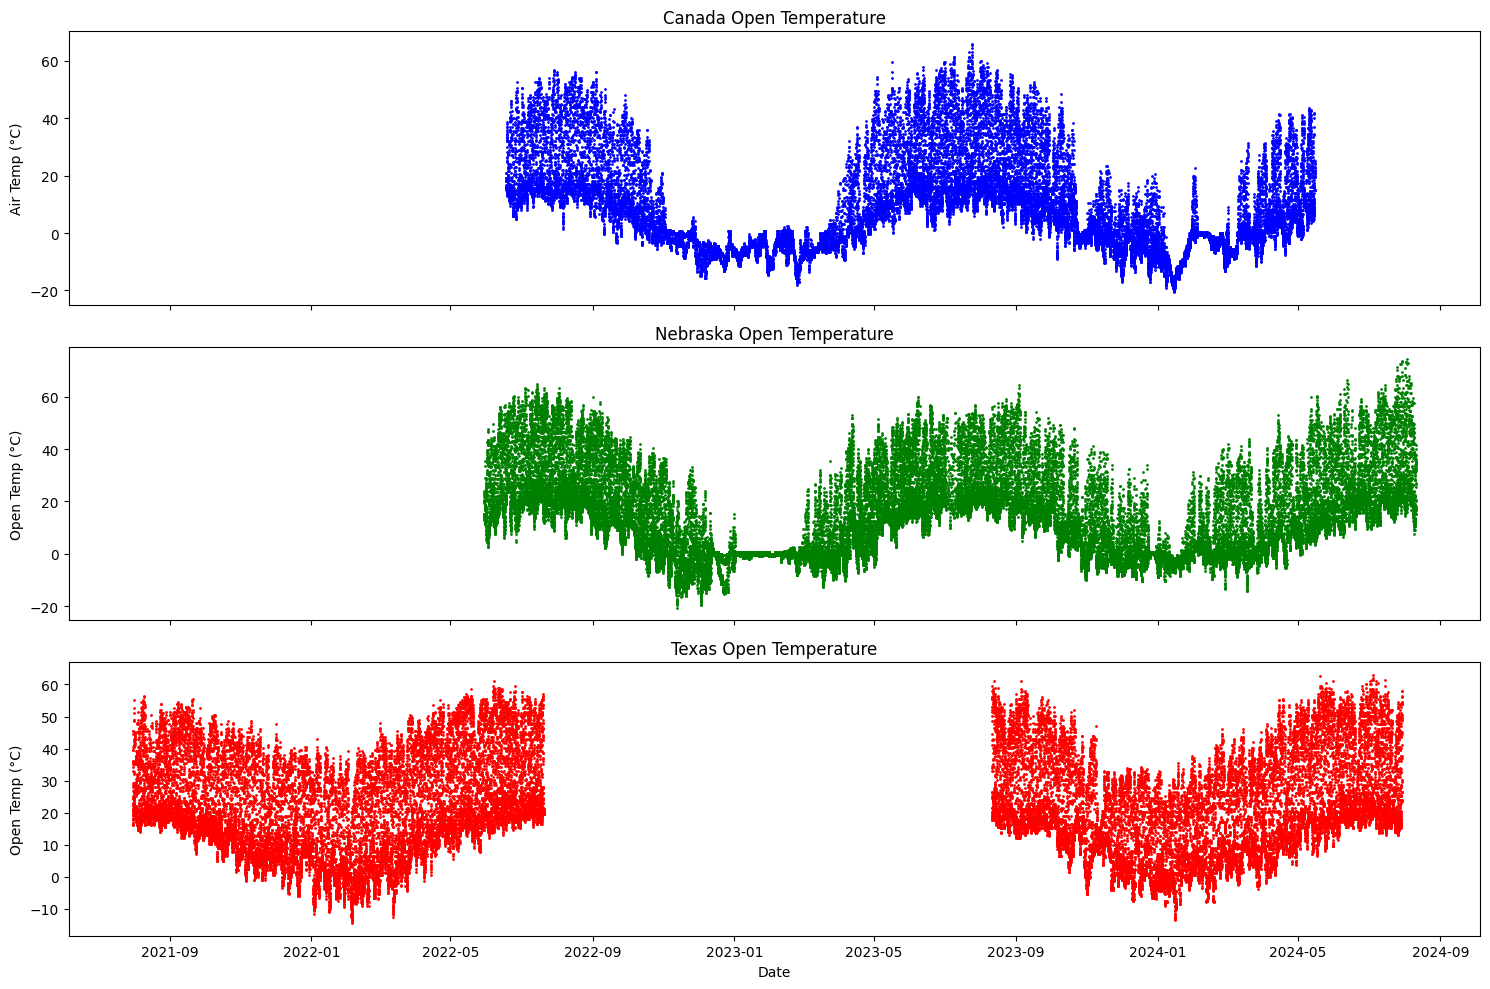

In [6]:
canada_df = otm_main[otm_main['Study_Site'] == 'Canada'].sort_values('Date').reset_index(drop=True)
nebraska_df = otm_main[otm_main['Study_Site'] == 'Nebraska'].sort_values('Date').reset_index(drop=True)
texas_df = otm_main[otm_main['Study_Site'] == 'Texas'].sort_values('Date').reset_index(drop=True)
fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

canada_open = canada_df[canada_df['Microhabitat'] == 'Open'].sort_values('Date').reset_index(drop=True)
nebraska_open = nebraska_df[nebraska_df['Microhabitat'] == 'Open'].sort_values('Date').reset_index(drop=True)
texas_open = texas_df[texas_df['Microhabitat'] == 'Open'].sort_values('Date').reset_index(drop=True)
canada_burrow = canada_df[canada_df['Microhabitat'] == 'Burrow'].sort_values('Date').reset_index(drop=True)
nebraska_burrow = nebraska_df[nebraska_df['Microhabitat'] == 'Burrow'].sort_values('Date').reset_index(drop=True)
texas_burrow = texas_df[texas_df['Microhabitat'] == 'Burrow'].sort_values('Date').reset_index(drop=True)
# Plot air temperatures
axes[0].scatter(canada_open['Date'], canada_open['Temperature'], label='Canada', color='blue', s=1)
axes[0].set_ylabel("Air Temp (°C)")
axes[0].set_title("Canada Open Temperature")

axes[1].scatter(nebraska_open['Date'], nebraska_open['Temperature'], label='Nebraska', color='green', s=1)
axes[1].set_ylabel("Open Temp (°C)")
axes[1].set_title("Nebraska Open Temperature")

axes[2].scatter(texas_open['Date'], texas_open['Temperature'], label='Texas', color='red', s=1)
axes[2].set_ylabel("Open Temp (°C)")
axes[2].set_title("Texas Open Temperature")
axes[2].set_xlabel("Date")

plt.tight_layout()
plt.show()

In [98]:
nebraska_df.head()

Microhabitat,Study_Site,month,day,hour,Burrow,Half_Burrow,Open,year,Date
8732,Nebraska,1,1,0,2.5425,0.022,-2.906286,2000,2000-01-01 00:00:00
8733,Nebraska,1,1,1,2.2920,-0.229,-3.194143,2000,2000-01-01 01:00:00
8734,Nebraska,1,1,2,2.0410,-0.966,-5.838667,2000,2000-01-01 02:00:00
8735,Nebraska,1,1,3,2.0410,-0.229,-3.050429,2000,2000-01-01 03:00:00
8736,Nebraska,1,1,4,2.0410,-0.229,-3.194000,2000,2000-01-01 04:00:00


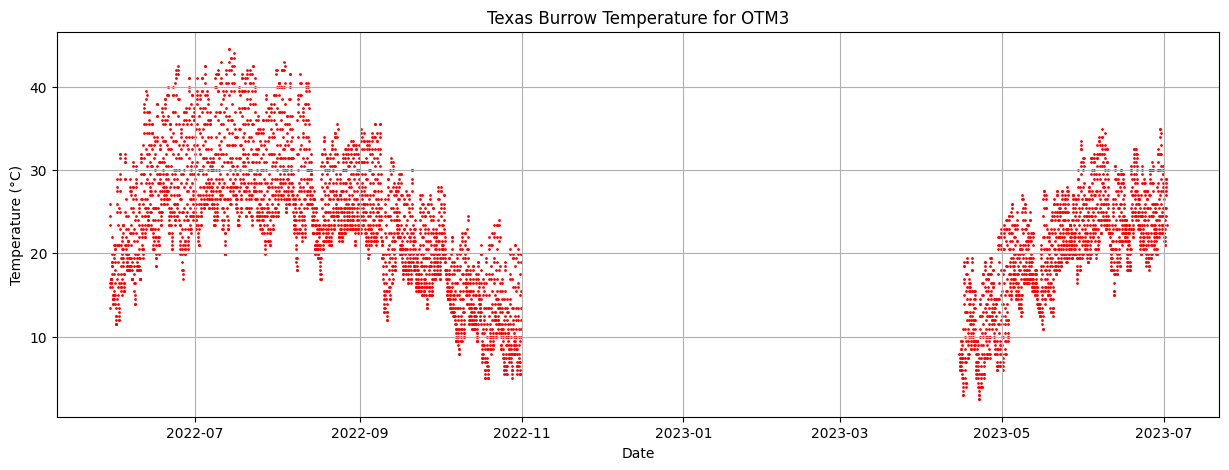

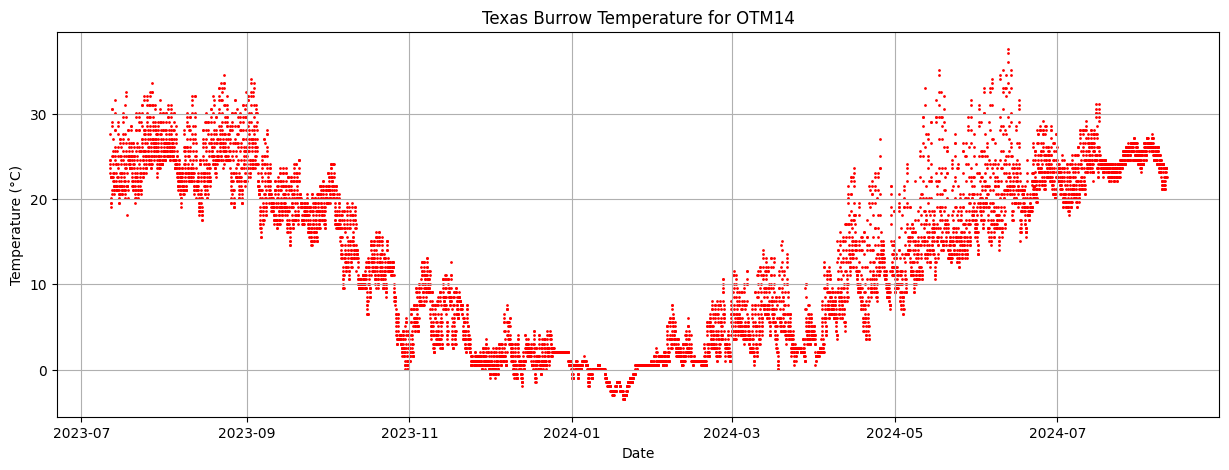

In [7]:
nebraska_half_burrow_df = nebraska_df[nebraska_df['Microhabitat'] == 'Half_Burrow'].sort_values('Date').reset_index(drop=True)


otm_ids = nebraska_half_burrow_df['OTM_ID'].unique()
for OTM_ID in otm_ids:
    plt.figure(figsize=(15, 5))
    plt.title(f"Texas Burrow Temperature for {OTM_ID}")
    plt.xlabel("Date")
    plt.ylabel("Temperature (°C)")
    plt.grid(True)
    
    # Filter data for the specific OTM_ID
    otm_data = nebraska_half_burrow_df[nebraska_half_burrow_df['OTM_ID'] == OTM_ID]
    
    # Plot the temperature data
    plt.scatter(otm_data['Date'], otm_data['Temperature'], label=OTM_ID, color='red', s=1)


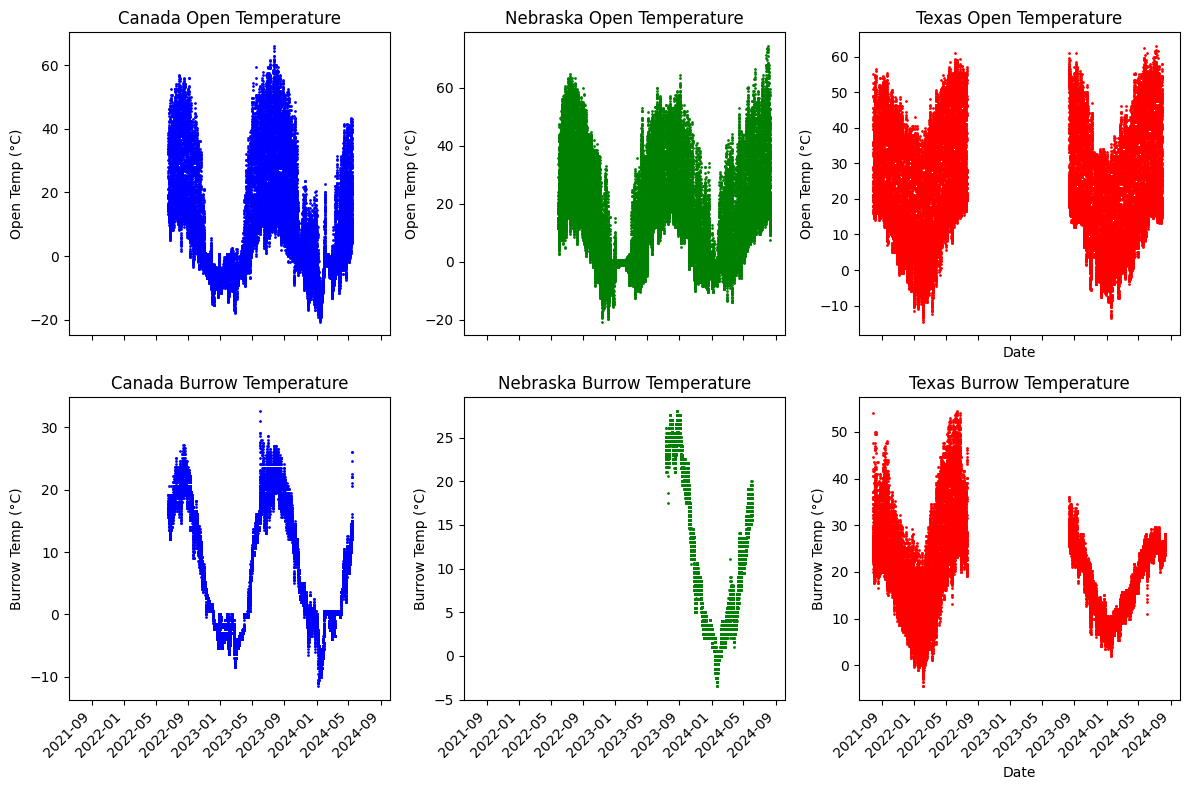

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=True)



axes[0,0].scatter(canada_open['Date'], canada_open['Temperature'], label='Canada', color='blue', s=1)
axes[0,0].set_ylabel("Open Temp (°C)")
axes[0,0].set_title("Canada Open Temperature")

axes[1,0].scatter(canada_burrow['Date'], canada_burrow['Temperature'], label='Canada', color='blue', s=1)
axes[1,0].set_ylabel("Burrow Temp (°C)")
axes[1,0].set_title("Canada Burrow Temperature")


axes[0,1].scatter(nebraska_open['Date'], nebraska_open['Temperature'], label='Nebraska', color='green', s=1)
axes[0,1].set_ylabel("Open Temp (°C)")
axes[0,1].set_title("Nebraska Open Temperature")

axes[1,1].scatter(nebraska_burrow['Date'], nebraska_burrow['Temperature'], label='Nebraska', color='green', s=1)
axes[1,1].set_ylabel("Burrow Temp (°C)")
axes[1,1].set_title("Nebraska Burrow Temperature")


axes[0,2].scatter(texas_open['Date'], texas_open['Temperature'], label='Texas', color='red', s=1)
axes[0,2].set_ylabel("Open Temp (°C)")
axes[0,2].set_title("Texas Open Temperature")
axes[0,2].set_xlabel("Date")

axes[1,2].scatter(texas_burrow['Date'], texas_burrow['Temperature'], label='Texas', color='red', s=1)
axes[1,2].set_ylabel("Burrow Temp (°C)")
axes[1,2].set_title("Texas Burrow Temperature")
axes[1,2].set_xlabel("Date")

for ax in axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')
        
plt.tight_layout()
plt.show()

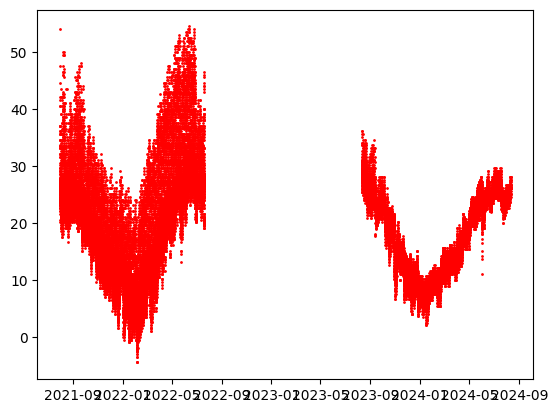

In [77]:
plt.scatter(texas_burrow['Date'], texas_burrow['Temperature'], label='Texas', color='red', s=1)


In [ ]:
otm_main.head()


,Date,Unit,Temperature,year,month,day,hour,minute,Study_Site,Microhabitat,OTM_ID,file_name
0,2022-06-17 23:00:01,C,22.580,2022,6,17,23,0,Canada,Air,Air Temperature,Air_Temp_CAN_2022.csv
1,2022-06-18 00:10:01,C,20.579,2022,6,18,0,10,Canada,Air,Air Temperature,Air_Temp_CAN_2022.csv
2,2022-06-18 01:20:01,C,21.079,2022,6,18,1,20,Canada,Air,Air Temperature,Air_Temp_CAN_2022.csv
3,2022-06-18 02:30:01,C,19.077,2022,6,18,2,30,Canada,Air,Air Temperature,Air_Temp_CAN_2022.csv
4,2022-06-18 03:40:01,C,18.077,2022,6,18,3,40,Canada,Air,Air Temperature,Air_Temp_CAN_2022.csv


In [9]:

otm_main_filtered = otm_main[otm_main['Microhabitat'].isin(['Open', 'Burrow', 'Half_Burrow'])].copy()
otm_main_filtered
df_pivot = (
    otm_main_filtered
    .pivot_table(
        index=['Study_Site', 'month', 'day', 'hour'],
        columns='Microhabitat',
        values='Temperature',
        aggfunc='median'  # take median instead of mean
    )
    .reset_index()
)
df_pivot['year'] = 2000
df_pivot['Date'] = pd.to_datetime(df_pivot[['year', 'month', 'day', 'hour']])
df_pivot.head()

Microhabitat,Study_Site,month,day,hour,Burrow,Half_Burrow,Open,year,Date
0,Canada,1,1,0,-1.2395,-2.4570,-3.463,2000,2000-01-01 00:00:00
1,Canada,1,1,1,-1.2395,-1.4840,-1.507,2000,2000-01-01 01:00:00
2,Canada,1,1,2,-1.2395,-1.7055,-1.960,2000,2000-01-01 02:00:00
3,Canada,1,1,3,-1.2395,-1.2250,-0.959,2000,2000-01-01 03:00:00
4,Canada,1,1,4,-0.9880,-0.7220,-0.000,2000,2000-01-01 04:00:00


In [10]:
canada_df = df_pivot[df_pivot['Study_Site'] == 'Canada']
nebraska_df = df_pivot[df_pivot['Study_Site'] == 'Nebraska']
texas_df = df_pivot[df_pivot['Study_Site'] == 'Texas']
nebraska_df.loc[:, "Burrow"] = nebraska_df["Burrow"].fillna(nebraska_df["Half_Burrow"]*.75)


In [11]:
len(canada_df), len(nebraska_df), len(texas_df)

(8732, 8479, 8781)

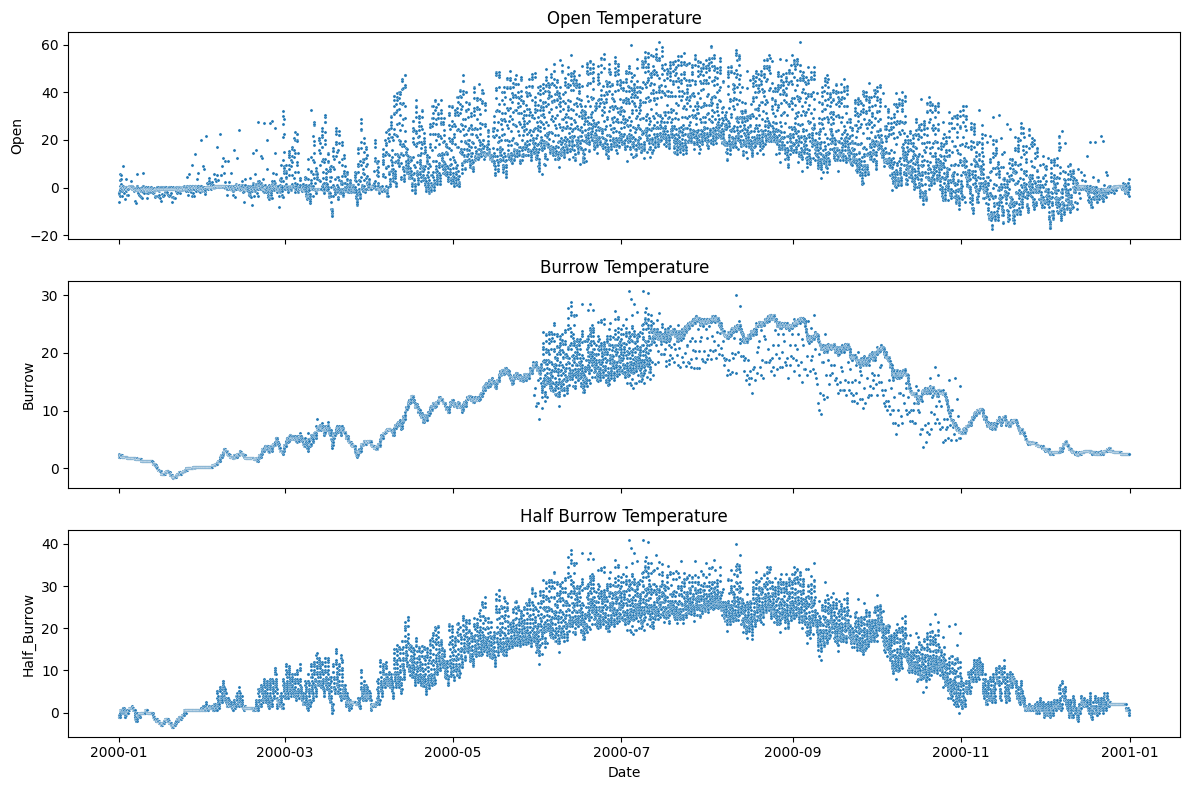

In [12]:
import seaborn as sns

fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

sns.scatterplot(
    data=nebraska_df, x='Date', y='Open', ax=axes[0], s=5
)
axes[0].set_title("Open Temperature")

sns.scatterplot(
    data=nebraska_df, x='Date', y='Burrow', ax=axes[1], s=5
)
axes[1].set_title("Burrow Temperature")

sns.scatterplot(
    data=nebraska_df, x='Date', y='Half_Burrow', ax=axes[2], s=5
)
axes[2].set_title("Half Burrow Temperature")

plt.tight_layout()
plt.show()

In [13]:

def hourly_snap_ffill(df):
    df = df.copy()
    df = df.set_index("Date")  # Ensure Date is datetime

    # Make a perfect hourly index
    full_index = pd.date_range(df.index.min(), df.index.max(), freq="60min")

    # Reindex and forward fill
    df = df.reindex(full_index).ffill()
    df.index.name = "Date"

    return df.reset_index()

# Apply
canada_df_resampled = hourly_snap_ffill(canada_df)
nebraska_df_resampled = hourly_snap_ffill(nebraska_df)
texas_df_resampled = hourly_snap_ffill(texas_df)




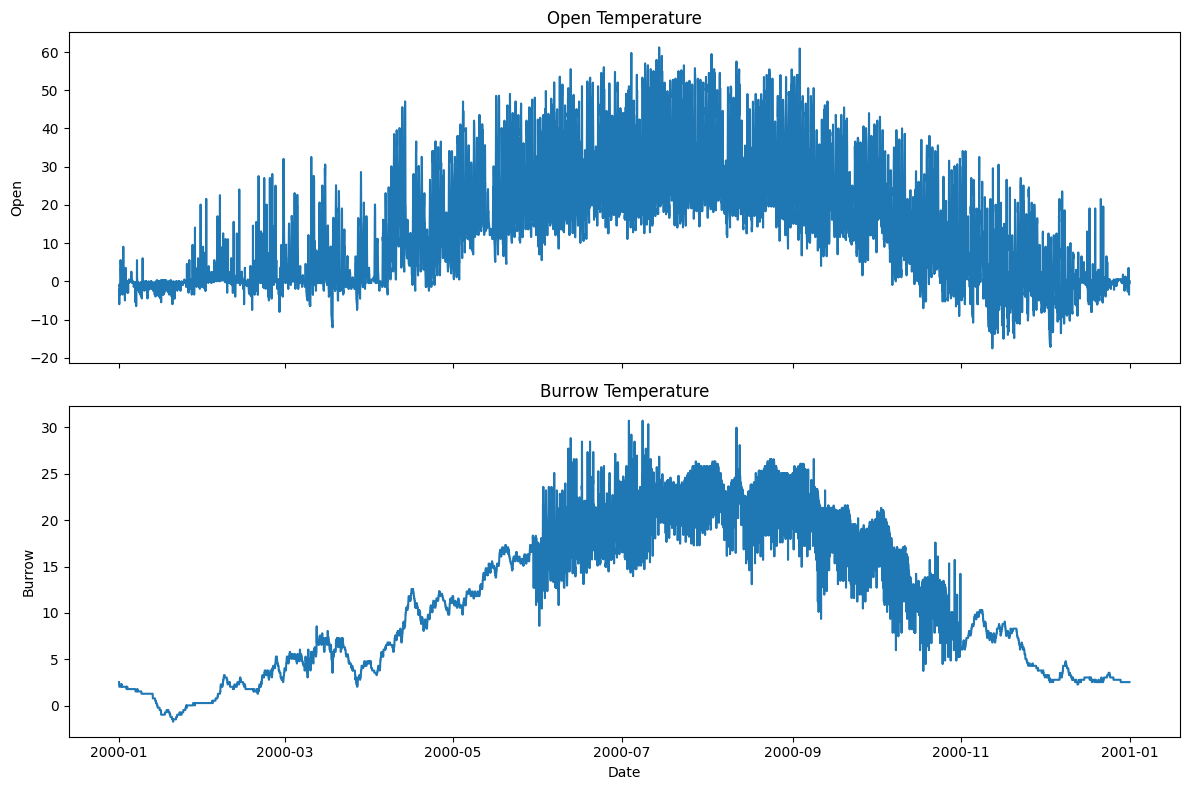

In [14]:
import seaborn as sns

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

sns.lineplot(
    data=nebraska_df_resampled, x='Date', y='Open', ax=axes[0]
)
axes[0].set_title("Open Temperature")

sns.lineplot(
    data=nebraska_df_resampled, x='Date', y='Burrow', ax=axes[1]
)
axes[1].set_title("Burrow Temperature")

plt.tight_layout()
plt.show()

In [15]:
len(canada_df_resampled), len(nebraska_df_resampled), len(texas_df_resampled)

(8784, 8784, 8784)

In [16]:
_resampled = [canada_df_resampled, nebraska_df_resampled, texas_df_resampled]

cleaned_data = []
for name, df in zip(["Canada", "Nebraska", "Texas"], _resampled):
    df = df.copy()  # avoid modifying original
    df["Date"] = pd.to_datetime(df["Date"])

    # Drop Feb 29
    is_feb29 = (df["Date"].dt.month == 2) & (df["Date"].dt.day == 29)
    df_clean = df.loc[~is_feb29]
    
    cleaned_data.append(df_clean)
    print(f"{name}: dropped {is_feb29.sum()} rows for Feb 29")

canada_df_clean, nebraska_df_clean, texas_df_clean = cleaned_data




Canada: dropped 24 rows for Feb 29
Nebraska: dropped 24 rows for Feb 29
Texas: dropped 24 rows for Feb 29


In [17]:
len(canada_df_clean), len(nebraska_df_clean), len(texas_df_clean)

(8760, 8760, 8760)

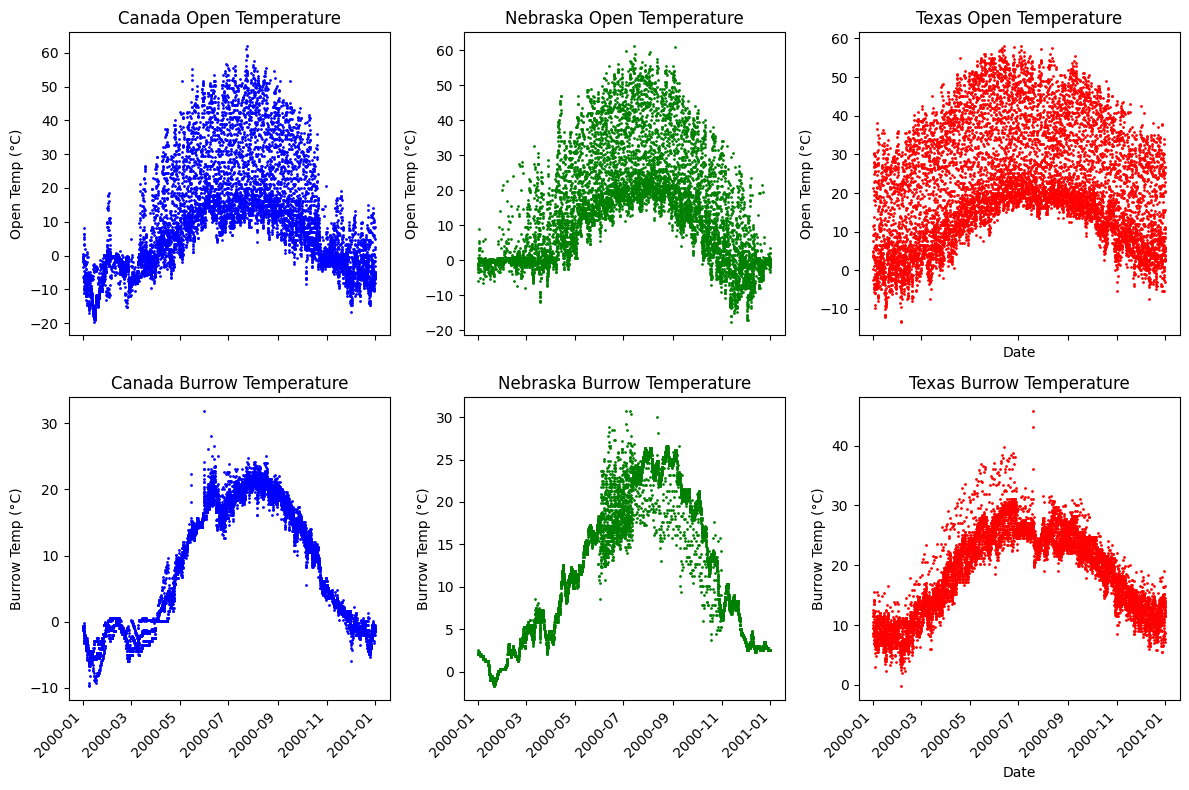

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=True)

axes[0,0].scatter(canada_df_clean['Date'], canada_df_clean['Open'], label='Canada', color='blue', s=1)
axes[0,0].set_ylabel("Open Temp (°C)")
axes[0,0].set_title("Canada Open Temperature")

axes[1,0].scatter(canada_df_clean['Date'], canada_df_clean['Burrow'], label='Canada', color='blue', s=1)
axes[1,0].set_ylabel("Burrow Temp (°C)")
axes[1,0].set_title("Canada Burrow Temperature")


axes[0,1].scatter(nebraska_df_clean['Date'], nebraska_df_clean['Open'], label='Nebraska', color='green', s=1)
axes[0,1].set_ylabel("Open Temp (°C)")
axes[0,1].set_title("Nebraska Open Temperature")

axes[1,1].scatter(nebraska_df_clean['Date'], nebraska_df_clean['Burrow'], label='Nebraska', color='green', s=1)
axes[1,1].set_ylabel("Burrow Temp (°C)")
axes[1,1].set_title("Nebraska Burrow Temperature")


axes[0,2].scatter(texas_df_clean['Date'], texas_df_clean['Open'], label='Texas', color='red', s=1)
axes[0,2].set_ylabel("Open Temp (°C)")
axes[0,2].set_title("Texas Open Temperature")
axes[0,2].set_xlabel("Date")

axes[1,2].scatter(texas_df_clean['Date'], texas_df_clean['Burrow'], label='Texas', color='red', s=1)
axes[1,2].set_ylabel("Burrow Temp (°C)")
axes[1,2].set_title("Texas Burrow Temperature")
axes[1,2].set_xlabel("Date")

for ax in axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')
        
plt.tight_layout()
plt.show()

In [19]:
data = [canada_df_clean, nebraska_df_clean, texas_df_clean]
for df in data:
    df['Open_1'] = df['Open']+1
    df['Burrow_1'] = df['Burrow']+1
    df['Open_2'] = df['Open']+2
    df['Burrow_2'] = df['Burrow']+2
    df['Open_3'] = df['Open']+3
    df['Burrow_3'] = df['Burrow']+3

In [20]:
start_month = 6  # June
start_day = 1

data = [canada_df_clean, nebraska_df_clean, texas_df_clean]
shifted_data = []

for df in data:
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])

    # Find start date for June 1 in that dataset's first year
    year_start = df['Date'].min().year
    start_date = pd.Timestamp(year=year_start, month=start_month, day=start_day)

    # Slice from start_date forward, then wrap around to the earlier part of the year
    df_reordered = pd.concat([
        df[df['Date'] >= start_date],
        df[df['Date'] < start_date]
    ])

    # Reset index for clean CSV
    df_reordered = df_reordered.reset_index(drop=True)

    shifted_data.append(df_reordered)

canada_df_clean, nebraska_df_clean, texas_df_clean = shifted_data

In [21]:
canada_df_clean.head()

Microhabitat,Date,Study_Site,month,day,hour,Burrow,Half_Burrow,Open,year,Open_1,Burrow_1,Open_2,Burrow_2,Open_3,Burrow_3
0,2000-06-01 00:00:00,Canada,6.0,1.0,0.0,18.074,19.132,16.562,2000.0,17.562,19.074,18.562,20.074,19.562,21.074
1,2000-06-01 01:00:00,Canada,6.0,1.0,1.0,18.074,18.631,16.550,2000.0,17.550,19.074,18.550,20.074,19.550,21.074
2,2000-06-01 02:00:00,Canada,6.0,1.0,2.0,18.074,18.131,15.047,2000.0,16.047,19.074,17.047,20.074,18.047,21.074
3,2000-06-01 03:00:00,Canada,6.0,1.0,3.0,17.573,18.131,16.049,2000.0,17.049,18.573,18.049,19.573,19.049,20.573
4,2000-06-01 04:00:00,Canada,6.0,1.0,4.0,17.094,18.131,16.049,2000.0,17.049,18.094,18.049,19.094,19.049,20.094


In [22]:
data = [canada_df_clean, nebraska_df_clean, texas_df_clean]
folder = '/home/micha/Documents/suffugium/environment_data/'
for df in data:
    df.to_csv(f"{folder}/{df['Study_Site'].iloc[0]}_cleaned.csv", index=False)